<a href="https://colab.research.google.com/github/iamviji/project/blob/master/misc/CommPy_ITPP_BER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/veeresht/CommPy.git
import sys
sys.path.append('./CommPy')

Cloning into 'CommPy'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 2061 (delta 113), reused 115 (delta 72), pack-reused 1883
Receiving objects: 100% (2061/2061), 1.43 MiB | 3.05 MiB/s, done.
Resolving deltas: 100% (1271/1271), done.


In [4]:
import commpy.channels as chan
import commpy.modulation as mod
import commpy.utilities as util
!pip install pyldpc

     |████████████████████████████████| 1.1MB 8.8MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=f58e1b0a39c2dc23da3332450dec4b70da0113c268996a76f9f3c3a3383c6d87
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc


In [5]:
import pyldpc
import numpy 
import time


In [25]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 8
num_bits_in_parity_check = 9 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [7]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message



In [26]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 9 channel_size= 18
input_message_size= 9 channel_size= 18
[[0 0 0 ... 0 1 1]
 [1 1 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 1 1 ... 0 1 0]
 [1 1 0 ... 1 0 1]
 [0 1 1 ... 0 0 1]]


In [27]:
import commpy
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)    
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_pyldpc=numpy.append(bler_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 4.75s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 9.74s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 14.90s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 19.90s
SNR: 0.000:
 -> BER: 0.66
 -> Total Time: 49.28s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 4.23s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 8.42s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 12.96s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 17.17s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 42.77s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 3.37s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 7.42s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 11.31s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 15.15s
SNR: 1.000:
 -> BER: 0.48
 -> Total Time: 37.25s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 2.72s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 5.78s
SNR: 1.500 - Iter: 750 - Last 25

In [17]:
modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_modulator  = numpy.array(())
times_per_iter_modulator= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_modulator=numpy.append(bler_per_iter_modulator ,ber)
  times_per_iter_modulator=numpy.append(times_per_iter_modulator, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.34s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.61s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 3.91s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.34s
SNR: 0.000:
 -> BER: 0.61
 -> Total Time: 13.20s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.27s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.55s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.85s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.12s
SNR: 0.500:
 -> BER: 0.59
 -> Total Time: 12.79s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.12s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.30s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.50s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.68s
SNR: 1.000:
 -> BER: 0.49
 -> Total Time: 11.60s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 1.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 2.09s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [28]:
modem = mod.PSKModem(4) #QPSK
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_qpsk  = numpy.array(())
times_per_iter_qpsk= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (encoded_message)
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    dmodem_output = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_qpsk=numpy.append(bler_per_iter_qpsk ,ber)
  times_per_iter_qpsk=numpy.append(times_per_iter_qpsk, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 5.60s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 11.32s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 16.71s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 22.24s
SNR: 0.000:
 -> BER: 0.81
 -> Total Time: 55.87s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 5.41s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 10.85s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 16.34s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 21.76s
SNR: 0.500:
 -> BER: 0.78
 -> Total Time: 54.36s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 5.39s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 10.74s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 16.26s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 21.66s
SNR: 1.000:
 -> BER: 0.73
 -> Total Time: 54.05s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 5.33s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 10.45s
SNR: 1.500 - Iter: 750 - Las

In [29]:
input_message_uncoded = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,9))

modem = mod.PSKModem(2)
awgn_channel = chan.SISOFlatChannel(None, (1 + 0j, 0j))

output_display_counter = NUM_OF_INPUT_MESSAGE/4
bler_per_iter_uncoded  = numpy.array(())
times_per_iter_uncoded= numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    #encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    #print(encoded_message)
    #encoded_message[encoded_message<0] = 0 #(convert modulation to channel encoding)
    #print(encoded_message)
    modem_output = modem.modulate (input_message_uncoded[i])
    #print (modem_output)
    awgn_channel.set_SNR_dB(snr)
    awgn_channel_output_message = awgn_channel.propagate(modem_output)
    #print (awgn_channel_output_message)
    decoded_message = modem.demodulate(awgn_channel_output_message, 'hard')
    #print (dmodem_output)
    #decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, dmodem_output, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message_uncoded[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  bler_per_iter_uncoded=numpy.append(bler_per_iter_uncoded ,ber)
  times_per_iter_uncoded=numpy.append(times_per_iter_uncoded, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 0.16s
SNR: 0.000:
 -> BER: 0.53
 -> Total Time: 0.40s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.13s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 0.17s
SNR: 0.500:
 -> BER: 0.48
 -> Total Time: 0.42s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.12s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 0.16s
SNR: 1.000:
 -> BER: 0.40
 -> Total Time: 0.39s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.04s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.08s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

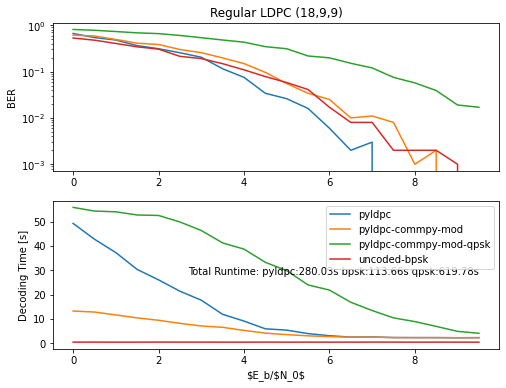

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_modulator,'', label="pyldpc-commpy-mod") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_qpsk,'', label="pyldpc-commpy-mod-qpsk") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded,'', label="uncoded-bpsk") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))

ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_modulator,'', label="pyldpc-commpy-mod") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_qpsk,'', label="pyldpc-commpy-mod-qpsk") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_uncoded,'', label="uncoded-bpsk") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s bpsk:{:03.2f}s qpsk:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_modulator), numpy.sum(times_per_iter_qpsk)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [1]:
!sudo apt-get install autoconf
!sudo apt-get install libtool
!sudo apt-get install liblapack-dev libblas-dev libfftw3-dev
!rm -rf itpp
!git clone https://github.com/iamviji/itpp.git # original one had compilation issue, did minor signle line change after forking
!ls;cd itpp;ls;mkdir -p build1 build2; cd build1 ; cmake cmake ..;make ;make install
!rm -rf py-itpp
!git clone https://github.com/vidits-kth/py-itpp.git
!pip3 install pybind11
!cd py-itpp;./install_prerequisites_python3.sh;make install;pip3 install -e .  
!cd py-itpp; ls ; pip3 install -e .  
!cat py-itpp/setup.py
import sys
!cp -rf py-itpp/lib/itpp py-itpp/lib/pyitpp # import itpp is not working, after this hack i started to work
sys.path.append('./py-itpp/lib')
#!pip install gwpy &> /dev/null

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  automake autotools-dev libsigsegv2 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc libtool gettext m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev libsigsegv2 m4
0 upgraded, 5 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,082 kB of archives.
After this operation, 3,994 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsigsegv2 amd64 2.12-1 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 m4 amd64 1.4.18-1 [197 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 autoconf all 2.69-11 [322 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 automake all 1:1.15.1-3ubuntu2 [509 kB]
Fet

In [2]:
import pyitpp as itpp
from matplotlib import pyplot as plt